# Data Processing 
This notebook will cover how we processed the data sets to be used in the model runners and other scripts.
- Receptor Binding Domain (RBD) Data Set
- Deep Mutational Scan (DMS) Data Set 
    - Expression
    - Binding
- AlphaSeq Data Set
- BetaCorona Data Set

In [1]:
import os
import re
import pandas as pd

import csv
import random
from Bio import SeqIO

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

--- 
## RBD

From our paper, this is how this data was collected: 
    All the SARS-CoV-2 spike protein sequences were downloaded from GISAID (Elbe and Buckland‐Merrett, 2017) as of version 20230203 followed by MD5-based search for deduplication and removal of sequences with a length shorter than 600aa or containing any unknown residues (X), we obtained a dataset of 312,888 unique sequences. Using the reference sequence of RDB region (YP_009724390:319..541), we performed similarity search against the dataset using DIAMOND blastp algorithm (Buchfink et al., 2021) and extracted 312,783 RBD regions that align with the complete 223aa RBD region. All the four data sets are available for download. Sequences and metadata from GISAID can be accessed using the EPI_SET ID: EPI_SET_231127oe.

## DMS
We utilize the DMS expression and binding data sets from the 'Deep Mutational Scanning of SARS-CoV-2 Receptor Binding Domain Reveals Constraints on Folding and ACE2 Binding' paper by Starr et al. We need to do some data processing prior to usage within our ML models. This portion of the notebook will cover the `process_dms.py` script.

We will need to utilize the below function for these DMS data sets. Given the below reference sequence, this applies the mutations present in the mutation label, or `aa_substitions` column in both .csv, to the reference sequence. This gives us our protein sequence that we later use in our models.

In [2]:
def label_to_seq(label: str) -> str:
    """ Generate sequence based on reference sequence and mutation label. """

    refseq = list('NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST')
    seq = refseq.copy()
    p = '([0-9]+)'
    if '_' in label:
        for mutcode in label.split('_'):
            [ori, pos, mut] = re.split(p, mutcode)
            pos = int(pos)-1    # use 0-based counting
            assert refseq[pos].upper() == ori
            seq[pos] = mut.upper()
        seq = ''.join(seq)
        return seq

    if label=='wildtype': return ''.join(seq)

    [ori, pos, mut] = re.split(p, label)
    pos = int(pos)-1    # use 0-based counting
    assert refseq[pos] == ori
    seq[pos] = mut.upper()
    seq = ''.join(seq)
    return seq

### Expression
Let's load in our first data set, `dms_expression_meanFs.csv` (renamed for organizational purposes, originally downloaded as `expression_meanFs.csv`). The following sections will be an expanded version of the function `process_data`. We will be focusing on 3 main columns to process our data: 
- `ML_meanF`, 
- `variant_class`, and 
- `aa_substitutions`.

In [3]:
data_dir = '../data'

# Load in .csv
expression_csv = os.path.join(data_dir, 'dms_expression_meanFs.csv')
expression_df = pd.read_csv(expression_csv, sep=',', header=0)
expression_df

,library,target,barcode,variant_call_support,total_count,ML_meanF,delta_ML_meanF,var_ML_meanF,variant_class,aa_substitutions,n_aa_substitutions
0,lib1,SARS-CoV-2,AAAAAAAAAATTGTAA,1,0.00,NaN,NaN,NaN,>1 nonsynonymous,Y91L K199Y,2
1,lib1,SARS-CoV-2,AAAAAAAAACTTAAAT,2,64.71,7.45,-3.01,0.04,>1 nonsynonymous,N13S L60P K94N S147T C150Y,5
2,lib1,SARS-CoV-2,AAAAAAAAACTTCAAT,5,117.96,7.92,-2.54,0.03,>1 nonsynonymous,A22C R127G E141D L188V,4
3,lib1,SARS-CoV-2,AAAAAAAACAAGCAGA,6,244.34,8.93,-1.53,0.01,1 nonsynonymous,N13F,1
4,lib1,SARS-CoV-2,AAAAAAAACAATATAA,1,95.35,6.21,-4.25,0.03,>1 nonsynonymous,C6K T15W K94Y V103W,4
...,...,...,...,...,...,...,...,...,...,...,...
195076,lib2,SARS-CoV-2,TTTTTTTACAGTCTTG,12,295.44,8.49,-1.89,0.02,1 nonsynonymous,Y165S,1
195077,lib2,SARS-CoV-2,TTTTTTTACCAGACTG,14,423.57,7.76,-2.62,0.01,>1 nonsynonymous,G83V D98L,2
195078,lib2,SARS-CoV-2,TTTTTTTCTTTAAAAA,7,159.59,7.68,-2.70,0.02,>1 nonsynonymous,V71H S147Q,2
195079,lib2,SARS-CoV-2,TTTTTTTGAAGCCCCA,8,98.22,10.38,0.00,0.03,wildtype,NaN,0


Nice, we have 195080 rows of data to start with. Now we want to drop the entries that have any NA/N values. This leaves us with 179005 remaining entries.

In [4]:
# Remove rows where specified column is NA
expression_df = expression_df.dropna(subset=['ML_meanF']).reset_index(drop=True)
print(len(expression_df))

179005


Let's take a look at how many of each `variant_class` there are. In the end, we want to filter out any variant classes that are not nonsynonymous mutations. We should have 147739 nonsynonymous mutations total.

In [5]:
# Count number of entries per variant class
value_counts = expression_df['variant_class'].value_counts()
print(value_counts)

# Filter out variant classes that are not nonsynonymous
nonsynonymous_df = expression_df[expression_df['variant_class'].str.contains('nonsynonymous', case=False, na=False)]
print(len(nonsynonymous_df))

variant_class
>1 nonsynonymous    120383
1 nonsynonymous      27356
stop                 21574
wildtype              8144
synonymous            1548
Name: count, dtype: int64
147739


Now we want to acquire the unique nonsynonymous mutations. We will do this by creating a new DataFrame taking the mean value of `ML_meanF` across each `aa_substitutions`. We then merge this new DataFrame with the older DataFrame containing only nonsynonymous mutations, replacing the old `ML_meanF` column with the new one with mean values for duplicate `aa_substitutions` nonsynonymous mutations. Then we drop any of these duplicates, leaving 116257 unique nonsynonymous mutations. 

We can also double check that we have no duplicates by counting the number of unique values in `aa_substitutions`. It matches with 116257 entries!

In [6]:
# Group by 'aa_substitutions' and calculate the mean of the specified value column for each group
unique_nonsynonymous_df = nonsynonymous_df.groupby('aa_substitutions', as_index=False)['ML_meanF'].mean()

# Merge dfs, replace duplicate with average
merged_df = pd.merge(unique_nonsynonymous_df, nonsynonymous_df.drop(columns='ML_meanF'), on='aa_substitutions', how='left')

# Drop duplicate rows based on 'aa_substitutions'
merged_df = merged_df.drop_duplicates(subset='aa_substitutions').reset_index(drop=True)
print(len(merged_df))

# Count number of unique nonsynonymous mutations
unique_nonsynonymous_mutations_counts = merged_df['aa_substitutions'].nunique()
print(f"Number of unique nonsynonymous mutations: {unique_nonsynonymous_mutations_counts}")

116257
Number of unique nonsynonymous mutations: 116257


Now we can select down to the columns we want, `aa_substitution` and `ML_meanF`. To match with the formatting of the `label_to_seq` function, we need to replace all spaces ' ' in `aa_substitutions` with underscores '_'. After, we can create a new column in our DataFrame containing the sequence (reference sequence with substitutions applied), and also rename the `aa_substitutions` to `labels`.

In [7]:
# Filter to only the columns we want and copy the DataFrame to avoid SettingWithCopyWarning
unique_filtered_df = merged_df[['aa_substitutions', 'ML_meanF']].copy()

# Add '_' to substitutions
unique_filtered_df.loc[:, 'aa_substitutions'] = unique_filtered_df['aa_substitutions'].replace(' ', '_', regex=True)

# Utilize 'aa_substitutions' to generate the mutated sequence
unique_filtered_df['sequence'] = unique_filtered_df['aa_substitutions'].apply(label_to_seq)

# Change 'aa_substitutions' to 'labels'
unique_filtered_df = unique_filtered_df.rename(columns={'aa_substitutions': 'labels'})
unique_filtered_df

,labels,ML_meanF,sequence
0,A105C,8.77,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
1,A105C_D112L_K128H_S147P,7.82,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
2,A105C_D112S,8.26,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3,A105C_F134V,8.05,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
4,A105C_G117S_L162T,7.84,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
...,...,...,...
116252,Y93W_V103W_T148R_G152R_T170L,7.18,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
116253,Y93W_Y119R,7.17,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
116254,Y93W_Y121P,7.61,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
116255,Y93W_Y123L_Y143E_Y159S,8.24,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


We save our data as a whole data set. Then, finally, we split our data into an 80/20 distribution between training and testing. We utilize the `split_csv` function from `split_data.py`, which splits the data 80/20 randomly based on the random seed (we use 0 as the random seed). 

In [8]:
def split_csv(rnd_seed: int, input_csv: str):
    """
    Split csv file into train, test data.
    """
    train_csv = input_csv.replace('.csv', '_train.csv')
    test_csv  = input_csv.replace('.csv', '_test.csv')

    with open(input_csv, "r") as input_file:
        reader = csv.reader(input_file)
        header = next(reader)
        input_records = list(reader)

    random.seed(rnd_seed)
    random.shuffle(input_records)

    split_idx = int(0.8 * len(input_records))
    train_records = input_records[:split_idx]
    test_records = input_records[split_idx:]

    with open(train_csv, 'w') as ft, open(test_csv, 'w') as fv:
        train_writer = csv.writer(ft)
        test_writer = csv.writer(fv)

        train_writer.writerow(header)
        test_writer.writerow(header)

        for record in train_records:
            train_writer.writerow(record)

        for record in test_records:
            test_writer.writerow(record)

    print(f'Total: {len(input_records)}, Train: {len(train_records)}, Test: {len(test_records)}')

In [9]:
# Save processed data to .csv
save_as = os.path.join(data_dir, 'dms_mutation_expression_meanFs.csv')
unique_filtered_df.to_csv(save_as, index=False)

# Split to train, test data (80/20)
rnd_seed = 0
split_csv(rnd_seed, save_as)

Total: 116257, Train: 93005, Test: 23252


Our final numbers for the processed data: 
- Total: 116257
    - Train: 93005
    - Test: 23252

We also have a separate file that includes all nonsynonmyous mutations. This is for observing the distributions found in `plot_dms_distribution.py`.

In [10]:
duplicate_filtered_df = nonsynonymous_df.copy()
duplicate_filtered_df.loc[:, 'aa_substitutions'] = duplicate_filtered_df['aa_substitutions'].replace(' ', '_', regex=True)
duplicate_filtered_df['sequence'] = duplicate_filtered_df['aa_substitutions'].apply(label_to_seq)
duplicate_filtered_df = duplicate_filtered_df.rename(columns={'aa_substitutions': 'labels'})

save_as = os.path.join(data_dir, 'dms_mutation_expression_meanFs.csv')
unique_filtered_df.to_csv(save_as, index=False)

### Binding
We can run the same process on the binding DMS data set.

Our final numbers for the processed data: 
- Total: 105525
    - Train: 84420
    - Test: 21105

In [11]:
def process_data(input_csv, output_csv):
    """ 
    Process the DMS binding and expression datasets.
    - Drop NAs
    - Select only nonsynonymous variant classes
    - Select unique nonsynonymous mutations
        - For duplicate aa_substitutions, take the mean value of log10Ka or ML_meanF
    - Apply mutations to reference sequence
    """

    if  "binding" in input_csv:
        value_column = "log10Ka"
        print("Looking at DMS binding dataset.")
    elif "expression" in input_csv:
        value_column = "ML_meanF"
        print("Looking at DMS expression dataset.")

    full_df = pd.read_csv(input_csv, sep=',', header=0)
    row_count = len(full_df)
    print(f"Number of data points: {row_count}")

    # Remove rows where specified column is NA
    full_df = full_df.dropna(subset=[value_column]).reset_index(drop=True)
    print(f"Number of data points with na: {row_count-len(full_df)}")
    print(f"Number of data points left {len(full_df)}")
    
    # Count number of entries per variant class
    value_counts = full_df["variant_class"].value_counts()
    print(f"{value_counts}")
    # Filter out variant classes that are not nonsynonymous
    nonsynonymous_df = full_df[full_df['variant_class'].str.contains('nonsynonymous', case=False, na=False)]
    
    # Group by 'aa_substitutions' and calculate the mean of the specified value column for each group
    unique_nonsynonymous_df = nonsynonymous_df.groupby('aa_substitutions', as_index=False)[value_column].mean()
    # Merge dfs
    merged_df = pd.merge(unique_nonsynonymous_df, nonsynonymous_df.drop(columns=value_column), on='aa_substitutions', how='left')
    # Drop duplicate rows based on 'aa_substitutions'
    merged_df = merged_df.drop_duplicates(subset='aa_substitutions').reset_index(drop=True)
    # Count number of unique nonsynonymous mutations
    unique_nonsynonymous_mutations_counts = merged_df['aa_substitutions'].nunique()
    print(f"Number of unique nonsynonymous mutations: {unique_nonsynonymous_mutations_counts}")
    
    # Filter to only the columns we want and copy the DataFrame to avoid SettingWithCopyWarning
    unique_filtered_df = merged_df[["aa_substitutions", value_column]].copy()
    duplicate_filtered_df = nonsynonymous_df.copy()
    # Add '_' to substitutions
    unique_filtered_df.loc[:, "aa_substitutions"] = unique_filtered_df["aa_substitutions"].replace(' ', '_', regex=True)
    duplicate_filtered_df.loc[:, "aa_substitutions"] = duplicate_filtered_df["aa_substitutions"].replace(' ', '_', regex=True)
    # Utilize "aa_substitutions" to generate the mutated sequence
    unique_filtered_df['sequence'] = unique_filtered_df['aa_substitutions'].apply(label_to_seq)
    duplicate_filtered_df['sequence'] = duplicate_filtered_df['aa_substitutions'].apply(label_to_seq)
    # Change "aa_substitutions" to "labels"
    unique_filtered_df = unique_filtered_df.rename(columns={"aa_substitutions": "labels"})
    duplicate_filtered_df = duplicate_filtered_df.rename(columns={"aa_substitutions": "labels"})
    
    # Save to csv
    unique_filtered_df.to_csv(output_csv, index=False)
    duplicate_output_csv = output_csv.replace("mutation", "duplicate_mutation")
    duplicate_filtered_df.to_csv(duplicate_output_csv, index=False)

    # Split to train, test data (80/20)
    rnd_seed = 0
    split_csv(rnd_seed, output_csv)
    print("")

In [12]:
binding_csv = os.path.join(data_dir, 'dms_binding_Kds.csv')
save_as = os.path.join(data_dir, 'dms_mutation_binding_Kds.csv')
process_data(binding_csv, save_as)

Looking at DMS binding dataset.


Number of data points: 195081
Number of data points with na: 48644
Number of data points left 146437
variant_class
>1 nonsynonymous    108365
1 nonsynonymous      27839
wildtype              8619
synonymous            1614
Name: count, dtype: int64
Number of unique nonsynonymous mutations: 105525
Total: 105525, Train: 84420, Test: 21105



### Distribution of Data
Let's take a look at some distributions of the data. First up, the function `plot_value_distribution` creates a plot that consists of the distribution of the measured binding or expression value. We plot this using the unique nonsynonymous mutation dataset. We will load from the .csv, just to make sure it was created properly.

In [13]:
def plot_value_distribution(df, value_col:str, save_as:str=None):
    """ 
    Plots the measured value (binding log10Ka or expression ML_meanF) distribution. 
    """
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style='white')
    plt.figure(figsize=(16, 9))
    plt.rcParams['font.family'] = 'sans-serif'

    # Create histogram and kde plot
    sns.histplot(df[value_col], kde=False, stat='density', bins=100, color='dimgrey', edgecolor='black')
    sns.kdeplot(df[value_col], color='red', linewidth=2)

    plt.tight_layout()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(f'Measured {value_col}', fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.show()

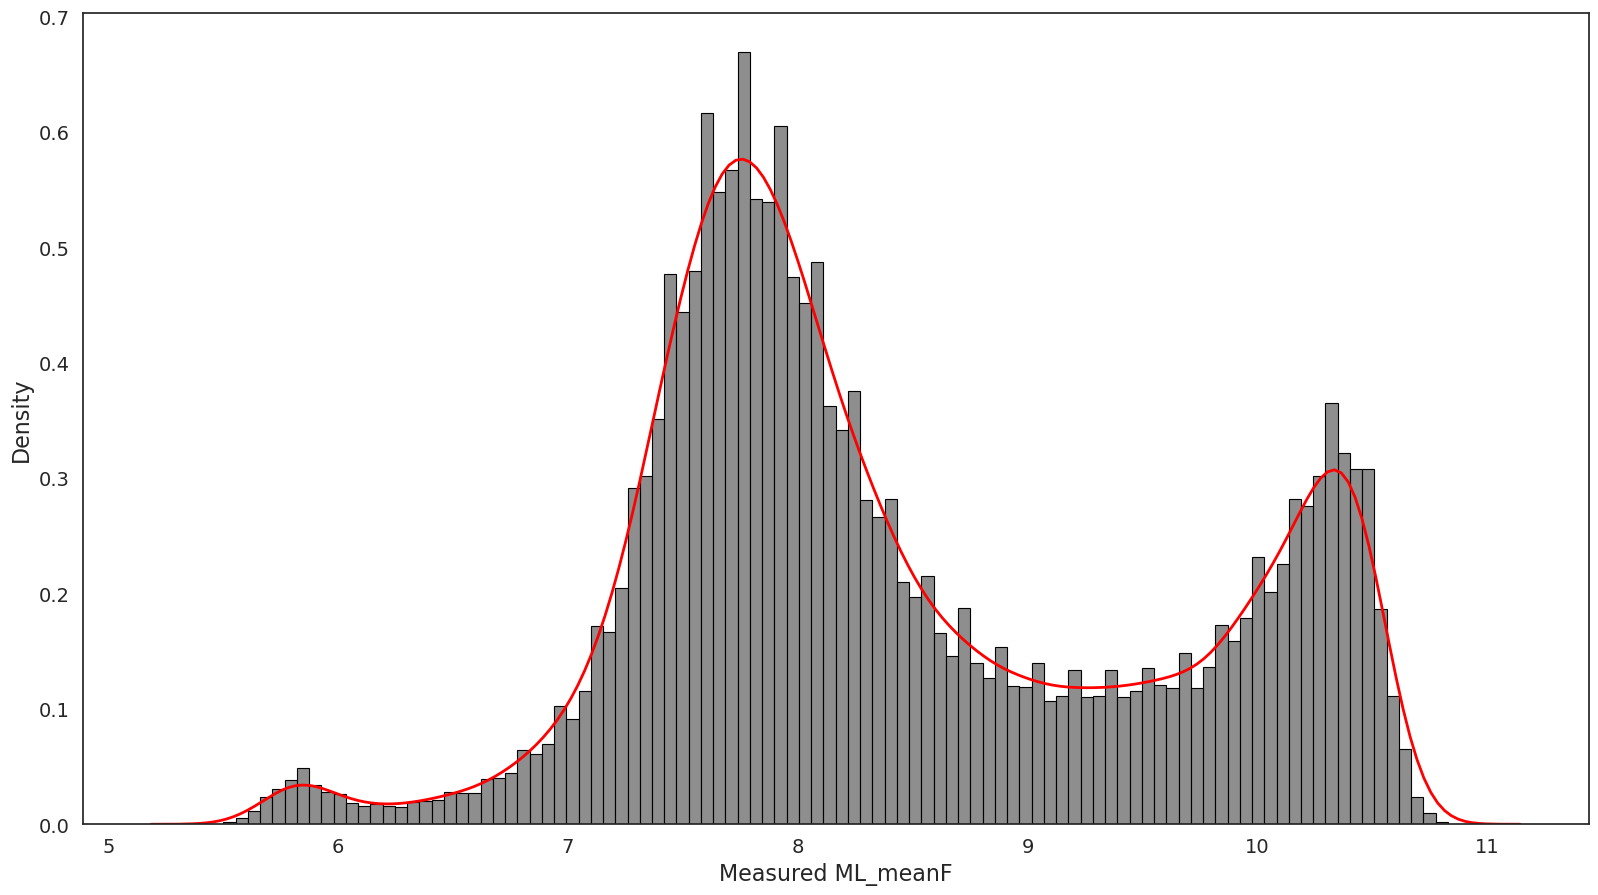

In [14]:
# Expression Data Set
expression_csv = os.path.join(data_dir, 'dms_duplicate_mutation_expression_meanFs.csv')
unique_expression_df = pd.read_csv(expression_csv, sep=',', header=0)
plot_value_distribution(unique_expression_df, 'ML_meanF')

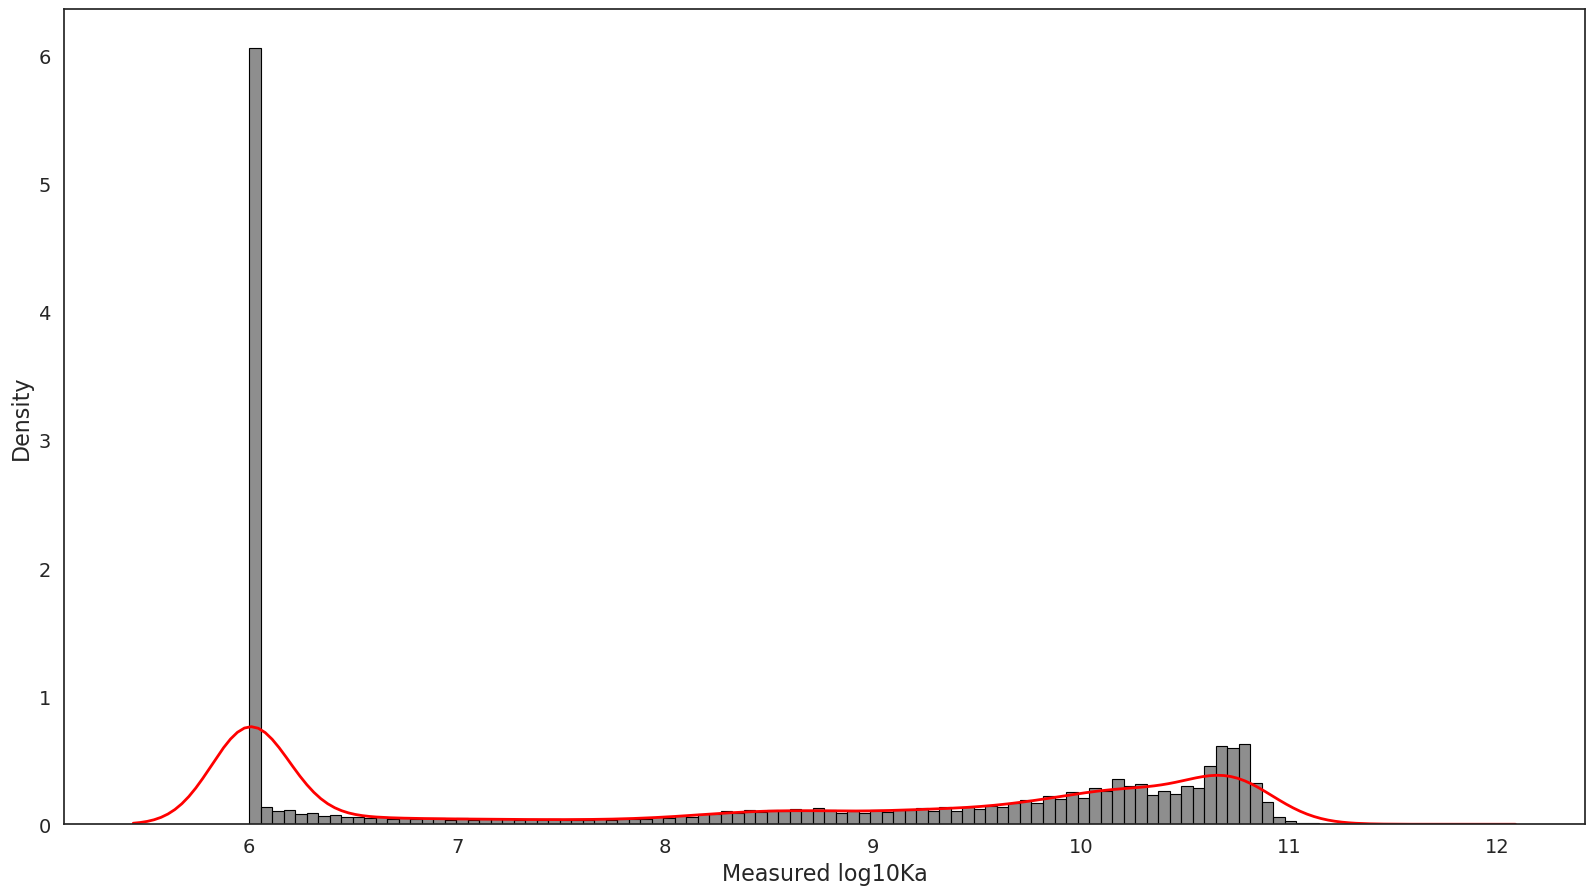

In [15]:
# Binding Data Set
binding_csv = os.path.join(data_dir, 'dms_duplicate_mutation_binding_Kds.csv')
unique_binding_df = pd.read_csv(binding_csv, sep=',', header=0)
plot_value_distribution(unique_binding_df, 'log10Ka')

We can also look at the distribution of (Root Mean Squared Error) RMSE values. We can then use these to compare to our model runs and their RMSE plots.

In [16]:
def plot_rmse_distribution(df, save_as:str=None):
    """ 
    Plots the RMSE density distribution for repeated sequences. 
    """
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style='white')
    plt.figure(figsize=(16, 9))
    plt.rcParams['font.family'] = 'sans-serif'

    # Create histogram and kde plot
    sns.histplot(df['rmse'], kde=False, stat='density', bins=100, color='dimgrey', edgecolor='black')
    sns.kdeplot(df['rmse'], color='red', linewidth=2)

    plt.tight_layout()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('RMSE', fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.show()

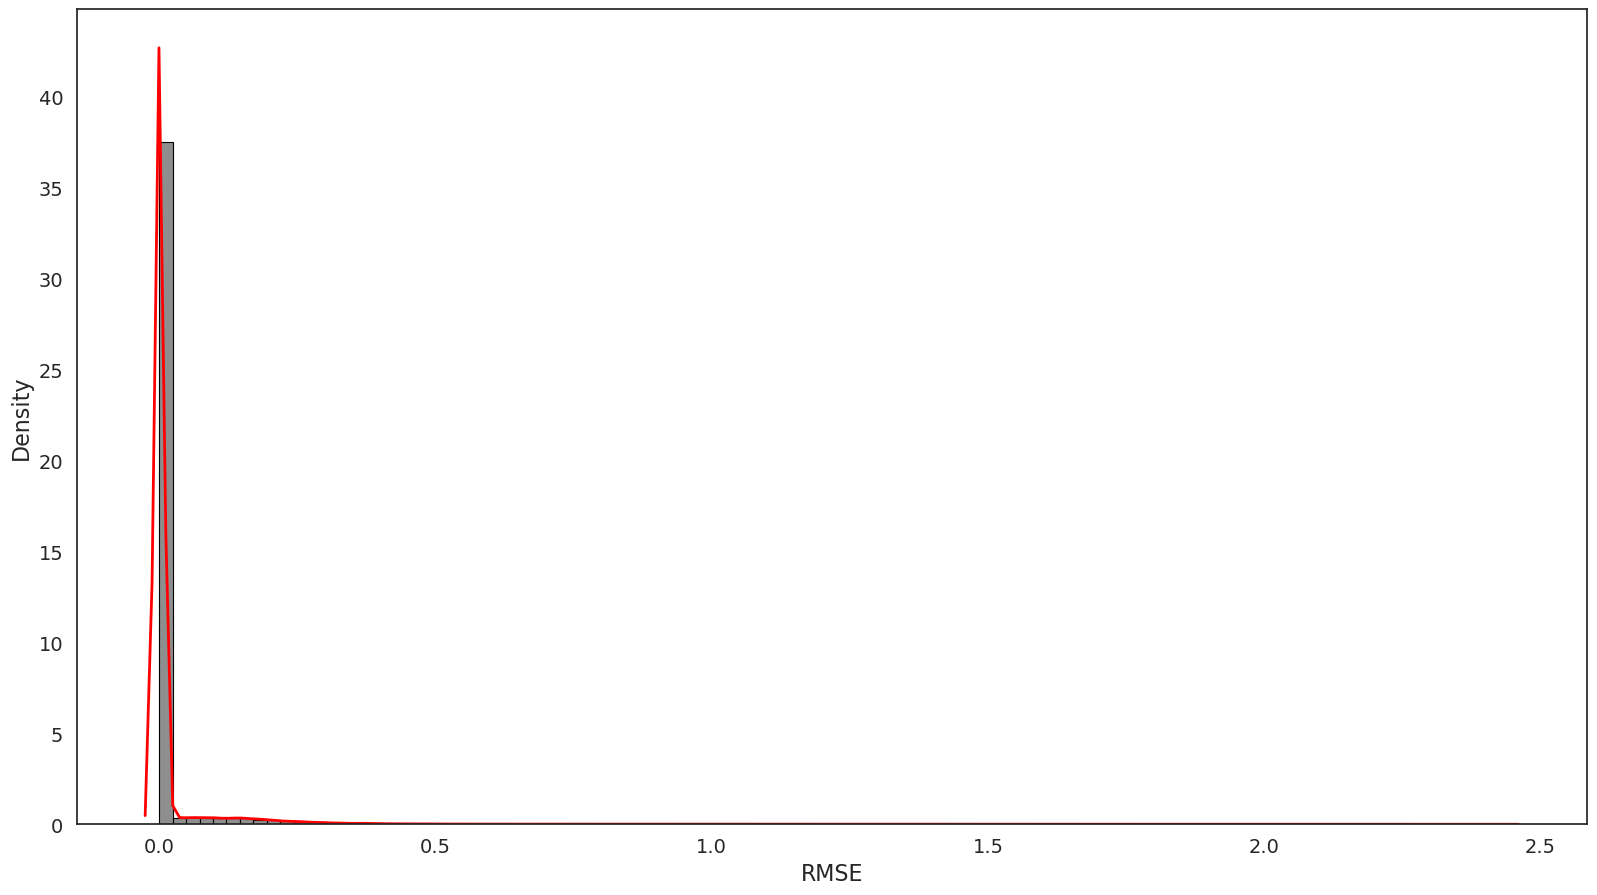

In [17]:
# Expression Data Set

# Mean ML_meanF and RMSE calculation
expression_df = pd.read_csv(expression_csv, sep=',', header=0)
expression_df = expression_df[['labels', 'ML_meanF', 'sequence']].copy()
expression_df['mean_ML_meanF'] = expression_df.groupby('labels')['ML_meanF'].transform('mean')
expression_df['squared_difference'] = (expression_df['ML_meanF'] - expression_df['mean_ML_meanF'])**2
expression_df['mse'] = expression_df.groupby('labels')['squared_difference'].transform('mean')
expression_df['rmse'] = np.sqrt(expression_df['mse'])
unique_expression_df = expression_df.drop_duplicates(subset='labels', keep='first')
plot_rmse_distribution(unique_expression_df)

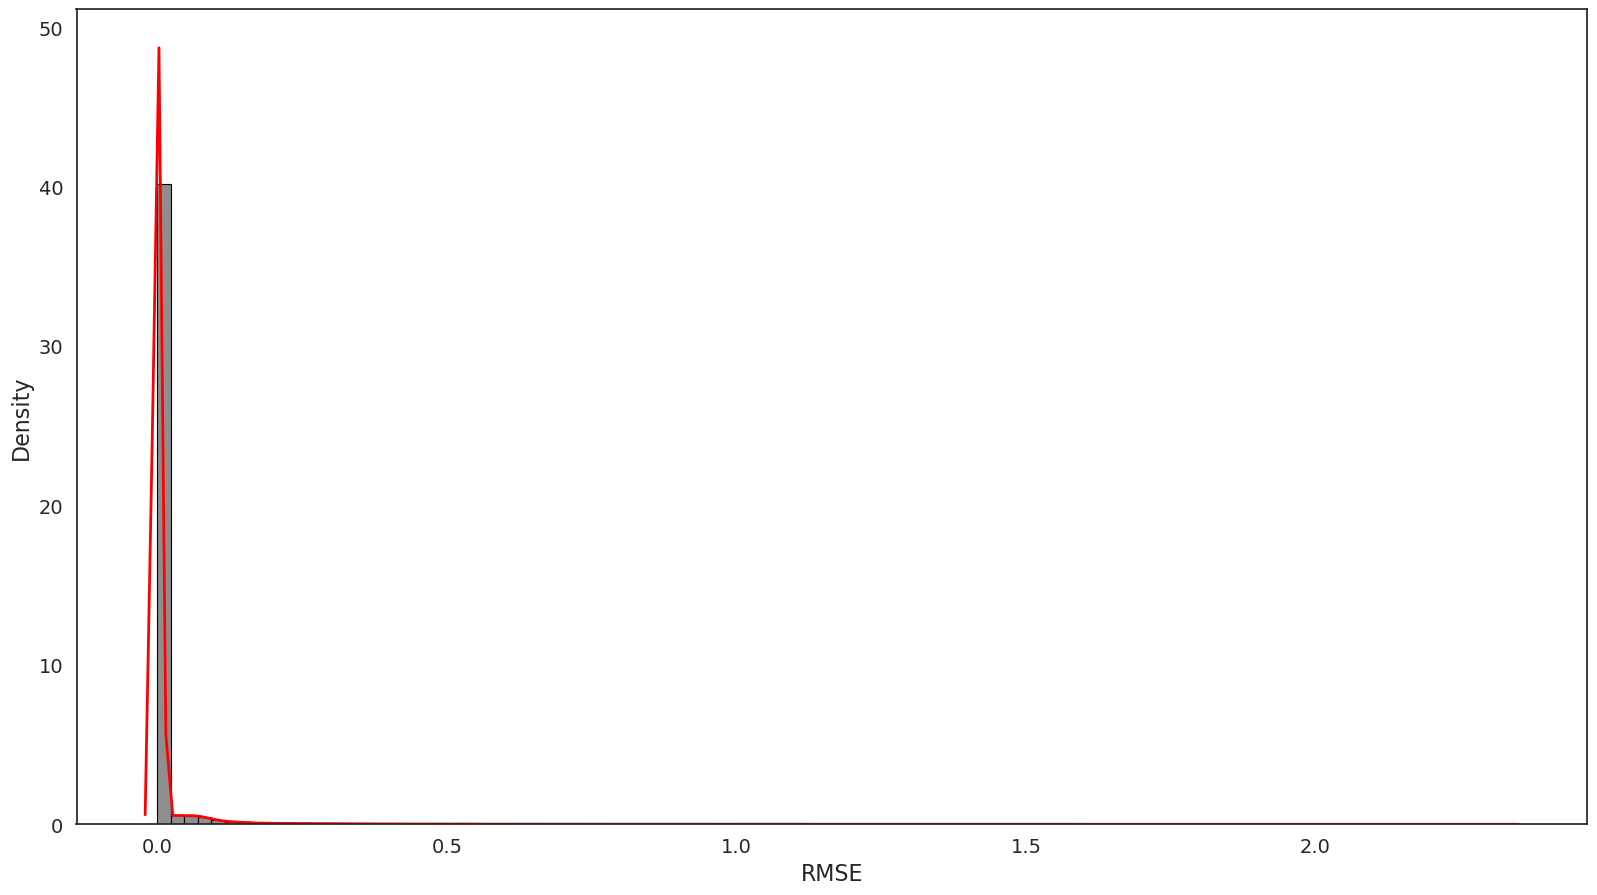

In [18]:
# Binding Data Set

# Mean log10KA and RMSE calculation 
binding_df = pd.read_csv(binding_csv, sep=',', header=0)
binding_df = binding_df[['labels', 'log10Ka', 'sequence']].copy()
binding_df['mean_log10Ka'] = binding_df.groupby('labels')['log10Ka'].transform('mean')
binding_df['squared_difference'] = (binding_df['log10Ka'] - binding_df['mean_log10Ka'])**2
binding_df['mse'] = binding_df.groupby('labels')['squared_difference'].transform('mean')
binding_df['rmse'] = np.sqrt(binding_df['mse'])
unique_binding_df = binding_df.drop_duplicates(subset='labels', keep='first')
plot_rmse_distribution(unique_binding_df)

---
## Beta-Corona Virus Data Set

Most of the data for the Beta-Corona Virus [data](https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS/blob/master/data/alignments/unaligned-sequences/RBDs.fasta) set was gathered from a [paper](https://www.sciencedirect.com/science/article/pii/S0092867420310035?via%3Dihub) conducted by Tyler Starr, Allie Greaney, and Jesse Bloom. 

The MERS sequences were manually extracted from querying the accession number ALA49374.1 through [blastp](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PAGE=Proteins&PROGRAM=blastp&PAGE_TYPE=BlastSearch&BLAST_SPEC=). After obtaining the FASTA file, we changed the FASTA file to a CSV. 

In [6]:
"""
Change Fasta file to csv
"""

import csv
from Bio import SeqIO

fasta_file = 'MERS_seq.fasta'
csv_file = 'MERS_seq.csv'

with open(csv_file, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['ID', 'Sequence'])  # Write header

    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        csvwriter.writerow([seq_record.id, str(seq_record.seq)])

After obtaining the CSV, we went through the sequences to find their RBD [region](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd21486). Using the RBD sequence, we went through 